# Демонстрация автоматического отбора признаков с помощью Permutation Importance

## Структура ноутбука:

- Применение библиотеки Permutation Importance для задач регрессии
    * Проверка Permutation Importance на доступных алгоритмах
    * Проверка всех библиотек Permutation Importance (sklearn, eli5, собственный kib) на CatBoostRegressor    

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, PermutationSelection, base_pipe

* sklearn:  0.24.2
* xgboost:  1.5.2
* matplotlib:  3.1.1
* autobinary:  1.0.3

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  0.24.2
xgboost:  1.5.2
matplotlib:  3.1.0
autobinary:  1.0.4


In [5]:
import numpy as np
np.__version__

'1.22.4'

In [6]:
import scipy
scipy.__version__

'1.8.1'

In [7]:
# eli5==0.13.0

# Для регрессии

In [8]:
sample = pd.read_csv('../data/train_houseprice.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [9]:
num_columns = [
    'LotArea', 'LotFrontage', 'TotalBsmtSF', 'PoolArea', 'FullBath'
]

cat_columns = [
    'BldgType', 'CentralAir', 'GarageQual', 'Fence', 'SaleType'
]

features = num_columns+cat_columns

target = ['SalePrice']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    sample[features],
    sample[target],
    test_size=0.3,
    random_state=42
)

In [11]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

In [12]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_val)

# 1. Использование библиотеки Auto Permutation

#### Проверка на нескольких моделях 

* Для выбора оптимального алгоритма, можно запустить метод на различных моделях бустинга, деревьев. Задаются словари параметров, листы со словарями и названием моделей. 

In [13]:
# Определение стандартных гиперпараметров моделей и список моделей

params_xgb = {
    'eta':0.01,
    'n_estimators':500,
    'subsample':0.9,
    'max_depth':6,
    'objective':'reg:squarederror',
    'n_jobs':-1,
    'random_state':42,
    'eval_metric':'rmse'}

params_ctb = {
    'learning_rate':0.01,
    'iterations':500,
    'subsample':0.9,
    'depth':6,
    'loss_function':'RMSE',
    'thread_count':-1,
    'random_state':42,
    'custom_metric':'RMSE',
    'verbose':0}

params_lgb = {
    'learning_rate':0.01,
    'n_estimators':500,
    'subsample':0.9,
    'max_depth':6,
    'objective':'regression',
    'n_jobs':-1,
    'random_state':42,
    'metric':'rmse'}

params_dt = {
             'max_depth':6,
             'random_state':42}

params_rf = {
             'max_depth':6,
             'random_state':42,
             'n_estimators':500}

params_list = [params_xgb, 
               params_ctb, 
               params_lgb, 
               params_dt, 
               params_rf
              ]

models_list = ['xgboost', 
               'catboost', 
               'lightboost', 
               'decisiontree', 
               'randomforest'
              ] 

### 1.1. Определяем класс PermutationSelection, куда передаем список из словарей параметров, список моделей, а также задаем тип задачи: "classification"/"multiclassification"/"regression"

* Далее запускаем метод обучения fit, куда передаем тренировочное множество (фолд из тренировочного множества, при больших выборках), и целевую переменную.


* Далее запускае метод calculate_permutation. Это основной метод для расчета метрик при перемешивании факторов. В метод передается тестовое множество (независимый фолд из тренировочного множества, при больших выборках), целевую переменную для тестового множества, количество перемешиваний фактора, способ Permutation Importance ("eli5"/"sklearn"/"kib"). Для более подробного описания метода, можно вызвать функцию shift+tab


* Все запускается циклом, для отбора более быстрого оптимального алгоритма.
    * Запуск требуется по желанию, если есть независимые фолды маленьких размеров.
    * Данный цикл является примером работы на всех доступных алгоритмах.

In [14]:
# Применение самописной библиотеки Permutation Importance (kib)

features_dict=dict()

for i in range(len(params_list)):
    
    perm_imp = PermutationSelection(
        model_type=models_list[i], 
        model_params=params_list[i], 
        task_type='regression')
    
    perm_imp.fit(
        X_train=new_X_train,
        y_train=y_train)
    
    perm_imp.calculate_permutation(
        X_test=new_X_valid, 
        y_test=y_val,
        n_iter=5,
        permute_type='kib',
        n_jobs=-1,
        metric=mean_absolute_percentage_error,
        higher_is_better=False)
    
    
    print('Модель: ', models_list[i],'\n')
    features_dict[models_list[i]] = perm_imp.select_features()
    print()

Расчет Permutation Importance на Train


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 781.91it/s]


Расчет Permutation Importance на Test


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7890.77it/s]


Модель:  xgboost 

11 признаков было до Permutation Importance 

10 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 15871.12it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 15151.84it/s]

Модель:  catboost 

11 признаков было до Permutation Importance 

10 признаков после Permutation Importance от kib



Расчет Permutation Importance на Train


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7978.10it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 21330.26it/s]


Модель:  lightboost 

11 признаков было до Permutation Importance 

9 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 15023.56it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 13702.80it/s]

Модель:  decisiontree 

11 признаков было до Permutation Importance 

6 признаков после Permutation Importance от kib



Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 11411.66it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 10438.31it/s]


Модель:  randomforest 

11 признаков было до Permutation Importance 

10 признаков после Permutation Importance от kib



* После обучения моделей получаем словари факторов для каждого из алгоритмов. Также можно отследить скорость обучения и выбрать подходящий для нас алгоритм

In [15]:
features_dict

{'xgboost': ['TotalBsmtSF',
  'FullBath',
  'LotArea',
  'BldgType',
  'CentralAir',
  'GarageQual',
  'SaleType',
  'LotFrontage',
  'Fence',
  'PoolArea'],
 'catboost': ['TotalBsmtSF',
  'FullBath',
  'LotArea',
  'CentralAir',
  'SaleType',
  'GarageQual',
  'BldgType',
  'LotFrontage',
  'Fence',
  'PoolArea'],
 'lightboost': ['TotalBsmtSF',
  'FullBath',
  'LotArea',
  'CentralAir',
  'BldgType',
  'GarageQual',
  'SaleType',
  'LotFrontage',
  'Fence'],
 'decisiontree': ['TotalBsmtSF',
  'FullBath',
  'BldgType',
  'LotArea',
  'CentralAir',
  'GarageQual'],
 'randomforest': ['TotalBsmtSF',
  'FullBath',
  'LotArea',
  'BldgType',
  'CentralAir',
  'GarageQual',
  'LotFrontage',
  'SaleType',
  'Fence',
  'PoolArea']}

* После анализа цикла, выбираем лучший алгоритм относительно скорость / качество. В нашем случае выбор выберем catboost и покажем на его примере.

## 2. Отбор признаков с помощью углубления древовидных алгоритмов

### 2.1. Задаем класс PermutationSelection. Передаем выборанный нами алгоритм, словарь параметров алгоритмы, а также тип решаемой задачи (покажем на примере catboost)

In [16]:
models_list[1]

'catboost'

In [17]:
params_list[1]

{'learning_rate': 0.01,
 'iterations': 500,
 'subsample': 0.9,
 'depth': 6,
 'loss_function': 'RMSE',
 'thread_count': -1,
 'random_state': 42,
 'custom_metric': 'RMSE',
 'verbose': 0}

In [18]:
perm_imp = PermutationSelection(
    model_type=models_list[1], 
    model_params=params_list[1], 
    task_type='regression')

### 2.2. Метод depth_analysis используется для отбора факторов относительно глубины алгоритма.

* В параметры передаются тренировочная выборка (фолд из тренировочной выборки), целевая переменная, список факторов и максимальная глубина до которой будут расчитываться важности признаков.


* На выходе мы получаем таблицу из факторов отсортированных по важности, таблицу из факторов отрсортированных по рангу признака, список факторов из отсортированных по важности, список факторов из отсортированных по рангу.


    * Аргоритм отбора относительно глубины: модель обучается на всех факторах в цикле с глубиной от 1 до максимально указанной. Далее выводятся важности по каждому признаку в каждой глубине. После чего значение усредняется по каждому признаку и сортируется по убыванию.
    
    * Алгоритм отбора относительно ранга в глубине: аналогично предыдущему, только при каждом значении глубины отбираются признаки со значением важности >0, по ним расставляются ранговые значения, и расчитывается среднее внутри каждой глубины. После чего ранги усредняются относительно глубин и сортируются по убыванию.

In [19]:
fi, fi_rank, depth_features, rank_features = perm_imp.depth_analysis(
    new_X_train, 
    y_train, 
    features,
    5)

  0%|          | 0/5 [00:00<?, ?it/s]

Количество признаков до отбора: 10
Количество признаков после mean importance относительно глубины: 10
Количество признаков после mean rank относительно глубины: 10


In [20]:
# Таблица важностей признаков относительно глубины

fi.head()

,importance_depth_1,importance_depth_2,importance_depth_3,importance_depth_4,importance_depth_5,mean_importance,mean_rank
TotalBsmtSF,46.962522,41.747351,38.284152,35.894621,33.627931,39.303315,0.185455
FullBath,30.428177,29.067838,28.989073,29.168358,29.227895,29.376268,0.166465
LotArea,12.038321,11.696827,11.991002,11.711556,12.242628,11.936067,0.147475
BldgType,2.351358,5.262407,7.001603,7.899342,8.133085,6.129559,0.120404
SaleType,4.335840,5.412221,5.971520,6.404530,6.547577,5.734338,0.117576


In [21]:
# Таблица рангов признаков относительно глубины

fi_rank.head()

,rank_depth_1,rank_depth_2,rank_depth_3,rank_depth_4,rank_depth_5,mean_rank
index,,,,,,
TotalBsmtSF,0.200000,0.181818,0.181818,0.181818,0.181818,0.185455
FullBath,0.177778,0.163636,0.163636,0.163636,0.163636,0.166465
LotArea,0.155556,0.145455,0.145455,0.145455,0.145455,0.147475
BldgType,0.111111,0.109091,0.127273,0.127273,0.127273,0.120404
SaleType,0.133333,0.127273,0.109091,0.109091,0.109091,0.117576


In [22]:
# Обновляем признаки после отбора по важностям или рангу относительно глубины

new_num_columns = list(filter(lambda x: x in num_columns, depth_features))
new_cat_columns = list(filter(lambda x: x in cat_columns, depth_features))

# 3. Проверка Permutation Importance на одной модели с разными алгоритмами sklearn, eli5, собственный код (kib)

    * Код является примером. Не обязательно использовать все три способа. Необходимо отталкиваться от размера выборки и типа задачи (классификация, мультикласс, регрессия). Для задач классификации наиболее оптимальными являются eli5 / kib. Для задач регрессии kib / sklearn.
    
    * Для начала применяем конвеер трансформации категориальных и численных признаков, после чего обучаем алгоритм при наших ранее заданных параметрах.

In [23]:
prep_pipe = base_pipe(
    num_columns=new_num_columns, 
    cat_columns=new_cat_columns, 
    kind='all')

prep_pipe.fit(X_train[depth_features], y_train)

new_X_train = prep_pipe.transform(X_train[depth_features])
new_X_valid = prep_pipe.transform(X_val[depth_features])

# Обучение алгоритма
perm_imp.fit(
    X_train=new_X_train,
    y_train=y_train)

### 3.1 От Sklearn

In [24]:
%%time

# От Sklearn

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_val,
    n_iter=15,
    permute_type='sklearn',
    n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 69.2 ms, sys: 11.8 ms, total: 81 ms
Wall time: 434 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
TotalBsmtSF,220.750175,91.119160
FullBath,170.164983,71.551743
LotArea,137.841558,57.647103
SaleType,50.847926,18.336513
BldgType,26.537764,14.631869
GarageQual,32.711879,10.486697
LotFrontage,32.511537,9.622099
CentralAir,33.363111,8.564518
Fence,15.197015,4.022369


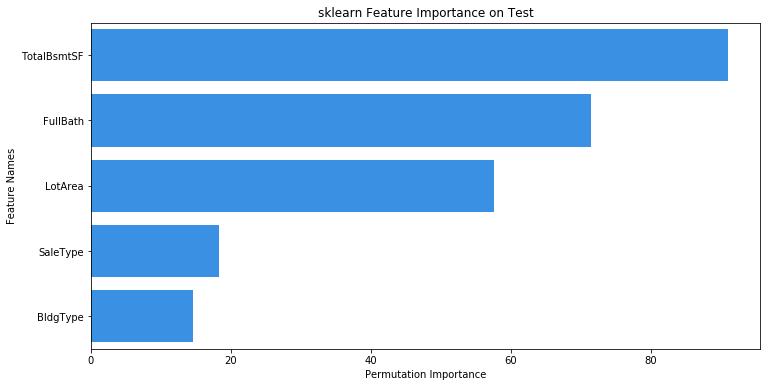

In [25]:
# вызов функции permutation_plot отрисовывает топ важности по методу permutation importance

perm_imp.permutation_plot(top=5, figsize=(12,6))

#### Вызов функции select_features выдает список отобранных признаков. 

* Отбор происходит следующим образом:
    * Если на тестовом множестве значение метрики относительно перемешанного факторо и рандомного признака ниже нуля, то отбираются все признаки выше нуля.
    * Если рандомный признак имеет положительное значение на тестовом множестве, то отбираются все признаки выше значения при рандомном признаке.

In [26]:
perm_imp.select_features()

11 признаков было до Permutation Importance 

9 признаков после Permutation Importance от sklearn


['TotalBsmtSF',
 'FullBath',
 'LotArea',
 'SaleType',
 'BldgType',
 'GarageQual',
 'LotFrontage',
 'CentralAir',
 'Fence']

### 3.2 От Eli5

In [27]:
%%time

# От Eli5

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_val,
    n_iter=15,
    permute_type='eli5',
#   n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 1.89 s, sys: 190 ms, total: 2.08 s
Wall time: 1.18 s


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
TotalBsmtSF,226.723277,93.823868
FullBath,168.479664,71.869676
LotArea,147.412751,55.042284
SaleType,51.767547,18.873177
BldgType,26.250021,15.879817
LotFrontage,32.865461,10.424180
CentralAir,33.654834,9.737823
GarageQual,33.277807,9.591808
Fence,15.410129,4.469577


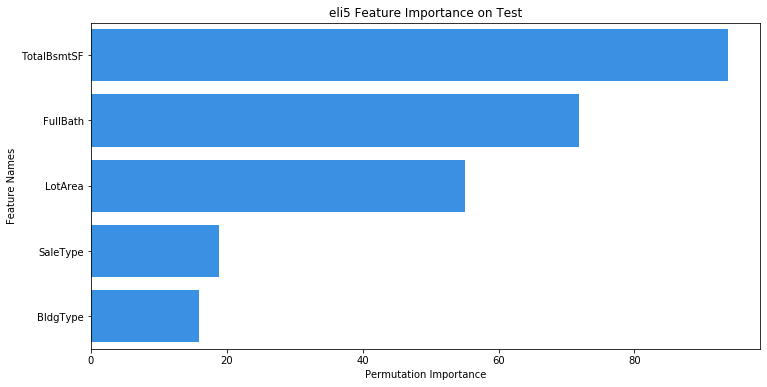

In [28]:
perm_imp.permutation_plot(top=5, figsize=(12,6))

In [29]:
perm_imp.select_features()

11 признаков было до Permutation Importance 

9 признаков после Permutation Importance от eli5


['TotalBsmtSF',
 'FullBath',
 'LotArea',
 'SaleType',
 'BldgType',
 'LotFrontage',
 'CentralAir',
 'GarageQual',
 'Fence']

### 3.3 Самописный permutation kib

In [30]:
%%time

# Самописный permutation

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_val,
    n_iter=15,
    permute_type='kib',
    n_jobs=-1,
    metric=mean_absolute_percentage_error,
    higher_is_better=False)

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 10273.29it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 11/11 [00:00<00:00, 26439.74it/s]

CPU times: user 55.1 ms, sys: 8.4 ms, total: 63.5 ms
Wall time: 193 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
TotalBsmtSF,0.409922,0.449625
FullBath,0.400166,0.443372
LotArea,0.349849,0.378941
SaleType,0.333166,0.369120
CentralAir,0.333818,0.368713
GarageQual,0.330999,0.368427
BldgType,0.335932,0.366453
LotFrontage,0.324048,0.360913
Fence,0.322998,0.360466


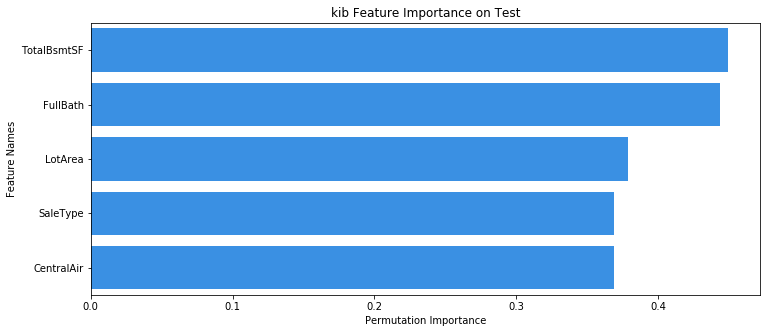

In [31]:
perm_imp.permutation_plot(top=5, figsize=(12,5))

In [32]:
perm_imp.select_features()

11 признаков было до Permutation Importance 

10 признаков после Permutation Importance от kib


['TotalBsmtSF',
 'FullBath',
 'LotArea',
 'SaleType',
 'CentralAir',
 'GarageQual',
 'BldgType',
 'LotFrontage',
 'Fence',
 'PoolArea']